# **Dependancies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/btc_data')

In [3]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


# **Loading Data**

In [4]:
import pandas as pd

# Đường dẫn đến file btc_data.csv
file_path = '/content/drive/My Drive/Colab Notebooks/btc_data/BTC_Data_2014-2022.csv'

# Đọc file CSV
data = pd.read_csv(file_path)


# Hiển thị 10 dòng đầu tiên
data.head(10)


,Date,priceUSD,size,sentbyaddress,transactions,mining_profitability,sentinusd,transactionfees,median_transaction_fee,confirmationtime,marketcap,transactionvalue,mediantransactionvalue,tweets,google_trends,fee_to_reward,activeaddresses,top100cap
0,2014/04/09,447.110,243742.0,122401,64992,38.678,239212041.0,0.1390,0.0447,8.944,5587996110,4115.0,100.420,8193,11.193,0.502,179274,19.211
1,2014/04/10,407.703,254334.0,124298,67872,31.917,310367120.0,0.0864,0.0408,9.290,5020359905,4876.0,120.946,15039,13.854,0.371,182996,19.166
2,2014/04/11,403.328,223656.0,117926,65563,36.814,292756343.0,0.0858,0.0403,8.521,5068919648,4819.0,108.481,14907,12.997,0.330,169622,19.141
3,2014/04/12,425.310,169964.0,87828,47579,34.498,157264741.0,0.0811,0.0425,8.944,5329088351,3574.0,84.408,7582,9.229,0.226,132283,19.145
4,2014/04/13,415.876,162260.0,94828,50981,34.141,154756367.0,0.0840,0.0416,7.701,5150414718,3332.0,69.681,10674,10.385,0.221,172708,19.131
5,2014/04/14,445.898,216048.0,127969,70026,37.973,253143718.0,0.0977,0.0446,7.461,5628122040,3990.0,115.249,13266,10.754,0.318,183291,19.146
6,2014/04/15,487.666,241539.0,123107,72627,38.650,293892234.0,0.1110,0.0488,7.912,6170470953,4479.0,123.089,14835,11.053,0.362,199054,19.124
7,2014/04/16,517.354,270984.0,114312,68435,40.201,389249585.0,0.1080,0.0517,9.057,6496569317,6046.0,129.799,15790,12.189,0.359,185075,19.146
8,2014/04/17,505.461,223631.0,102596,65021,40.706,385378002.0,0.1170,0.0505,8.521,6281237538,6384.0,102.416,15215,11.471,0.355,157751,19.092
9,2014/04/18,485.296,205478.0,100633,56836,35.818,360602878.0,0.1040,0.0485,9.000,5972292967,6461.0,107.713,14028,9.946,0.304,149452,19.054


# **Model Architecture + Training**

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Model
from keras.layers import Input, Dense, LayerNormalization, Dropout
from keras.layers import MultiHeadAttention, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping
from keras_tuner import HyperModel, RandomSearch
import tensorflow as tf

# 1. Load and preprocess data with 80-10-10 split
def load_and_preprocess_data(data):
    X = data.drop(columns=['priceUSD', 'Date'])
    y = data['priceUSD']

    n = len(X)
    train_end = int(n * 0.8)
    val_end = int(n * 0.9)

    X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
    y_train, y_val, y_test = y.iloc[:train_end], y.iloc[train_end:val_end], y.iloc[val_end:]

    scaler = MinMaxScaler()
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_val_scaled = scaler.transform(y_val.values.reshape(-1, 1))
    y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

    return X_train, X_val, X_test, y_train_scaled, y_val_scaled, y_test_scaled, scaler

# 2. Define Transformer HyperModel with corrected output shape and AdamW optimizer
class TransformerHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape  # e.g. (num_features, 1)

    def build(self, hp):
        inputs = Input(shape=self.input_shape)  # shape (features, 1)
        x = Dense(hp.Int('units', 64, 256, step=64), activation='relu')(inputs)
        x = LayerNormalization()(x)
        x = Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1))(x)

        for _ in range(hp.Int('num_transformer_blocks', 1, 3)):
            x = self.transformer_block(x, hp)

        x = GlobalAveragePooling1D()(x)  # shape (batch_size, features)

        output = Dense(1)(x)  # Dự đoán 1 giá trị cho mỗi mẫu

        model = Model(inputs=inputs, outputs=output)

        learning_rate = hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')
        weight_decay = hp.Float('weight_decay', 1e-5, 1e-3, sampling='log', default=1e-4)

        optimizer = tf.keras.optimizers.AdamW(
            learning_rate=learning_rate,
            weight_decay=weight_decay
        )

        model.compile(optimizer=optimizer, loss='mse')
        return model

    def transformer_block(self, x, hp):
        num_heads = hp.Choice('num_heads', [2, 3, 4])
        key_dim = hp.Choice('key_dim', [32, 48])
        ff_units = hp.Choice('units_ff', [128, 256])

        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
        attn_output = Dropout(0.1)(attn_output)
        x = LayerNormalization()(x + attn_output)

        ff = Dense(ff_units, activation='relu')(x)
        last_dim = int(x.shape[-1])
        ff = Dense(last_dim)(ff)
        ff = Dropout(0.1)(ff)
        x = LayerNormalization()(x + ff)
        return x

# 3. Train Transformer with Validation
def train_transformer(X_train, y_train, X_val, y_val):
    X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val_reshaped = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)

    input_shape = (X_train.shape[1], 1)
    hypermodel = TransformerHyperModel(input_shape=input_shape)
    tuner = RandomSearch(hypermodel,
                         objective='val_loss',
                         max_trials=80,
                         executions_per_trial=1,
                         directory='my_dir',
                         project_name='transformer_optimization')

    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

    tuner.search(X_train_reshaped, y_train,
                 epochs=300, batch_size=32,
                 validation_data=(X_val_reshaped, y_val),
                 callbacks=[early_stopping])

    print("Các tham số của tất cả các mô hình đã chạy:")
    for trial in tuner.oracle.trials.values():
        print(f"Trial ID: {trial.trial_id}")
        print(f"Parameters: {trial.hyperparameters.values}")
        print(f"Learning Rate: {trial.hyperparameters.get('learning_rate')}")
        print(f"Weight Decay: {trial.hyperparameters.get('weight_decay')}")
        print(f"Score: {trial.score}\n")

    best_model = tuner.get_best_models(num_models=1)[0]
    return best_model

# 4. Evaluate Model
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    nonzero_idx = y_true != 0
    if np.any(nonzero_idx):
        mape = np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100
    else:
        mape = np.nan
    return mae, rmse, r2, mse, mape

# 5. Main Execution
save_dir = '/content/drive/My Drive/Colab Notebooks/btc_data/Training_Transformer_AdamW_V2'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Giả sử biến `data` đã được load sẵn (pandas DataFrame)
X_train, X_val, X_test, y_train, y_val, y_test, scaler = load_and_preprocess_data(data)

# Train Transformer với AdamW
transformer_model = train_transformer(X_train, y_train, X_val, y_val)

# Dự đoán trên tập train và val
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)

transformer_pred_train = transformer_model.predict(X_train_reshaped)
transformer_pred_val = transformer_model.predict(X_val_reshaped)

# Inverse transform
transformer_pred_train_original = scaler.inverse_transform(transformer_pred_train)
transformer_pred_val_original = scaler.inverse_transform(transformer_pred_val)

y_train_original = scaler.inverse_transform(y_train)
y_val_original = scaler.inverse_transform(y_val)

# Evaluate trên train và val nếu cần
mae_train, rmse_train, r2_train, mse_train, mape_train = evaluate_model(
    y_train_original.flatten(), transformer_pred_train_original.flatten())

mae_val, rmse_val, r2_val, mse_val, mape_val = evaluate_model(
    y_val_original.flatten(), transformer_pred_val_original.flatten())

# Dự đoán trên tập test
X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
transformer_pred_test = transformer_model.predict(X_test_reshaped)

y_test_original = scaler.inverse_transform(y_test)
transformer_pred_test_original = scaler.inverse_transform(transformer_pred_test)

# Evaluate test
mae, rmse, r2, mse, mape = evaluate_model(y_test_original.flatten(), transformer_pred_test_original.flatten())

print(f'Test MAE: {mae}')
print(f'Test RMSE: {rmse}')
print(f'Test R2: {r2}')
print(f'Test MSE: {mse}')
print(f'Test MAPE: {mape}%')

# Save results
results = pd.DataFrame({
    'Actual': y_test_original.flatten(),
    'Predicted': transformer_pred_test_original.flatten()
})
print(results.head(10))
results_path = os.path.join(save_dir, 'result_predictions_Transformer_AdamW_model.csv')
results.to_csv(results_path, index=False)
print(f"Predictions saved to: {results_path}")

transformer_model_path = os.path.join(save_dir, 'Transformer_AdamW_model.keras')
transformer_model.save(transformer_model_path)
print(f"Transformer AdamW model saved to: {transformer_model_path}")


Trial 80 Complete [00h 08m 15s]
val_loss: 0.21461208164691925

Best val_loss So Far: 0.0524693988263607
Total elapsed time: 07h 25m 03s
Các tham số của tất cả các mô hình đã chạy:
Trial ID: 00
Parameters: {'units': 128, 'dropout_rate': 0.2, 'num_transformer_blocks': 1, 'num_heads': 3, 'key_dim': 48, 'units_ff': 256, 'learning_rate': 0.00041358882142530375, 'weight_decay': 0.00021997896716484435}
Learning Rate: 0.00041358882142530375
Weight Decay: 0.00021997896716484435
Score: 0.3064725399017334

Trial ID: 01
Parameters: {'units': 192, 'dropout_rate': 0.2, 'num_transformer_blocks': 3, 'num_heads': 4, 'key_dim': 48, 'units_ff': 128, 'learning_rate': 0.0007723237815881982, 'weight_decay': 0.0002140192612726292}
Learning Rate: 0.0007723237815881982
Weight Decay: 0.0002140192612726292
Score: 0.2023462951183319

Trial ID: 02
Parameters: {'units': 192, 'dropout_rate': 0.1, 'num_transformer_blocks': 1, 'num_heads': 2, 'key_dim': 32, 'units_ff': 256, 'learning_rate': 0.0004599481771814891, 'wei

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Test MAE: 9712.7641570853
Test RMSE: 10550.842239375697
Test R2: -0.19385864592750757
Test MSE: 111320271.96019438
Test MAPE: 44.90619376193849%
    Actual     Predicted
0  43854.0  36722.566406
1  43922.0  36668.085938
2  44331.0  36708.429688
3  43185.0  36590.035156
4  42333.0  36809.992188
5  42336.0  35997.988281
6  42232.0  35996.027344
7  43867.0  36588.617188
8  43998.0  36002.476562
9  42666.0  35975.996094
Predictions saved to: /content/drive/My Drive/Colab Notebooks/btc_data/Training_Transformer_AdamW_V2/result_predictions_Transformer_AdamW_model.csv
Transformer AdamW model saved to: /content/drive/My Drive/Colab Notebooks/btc_data/Training_Transformer_AdamW_V2/Transformer_AdamW_model.keras


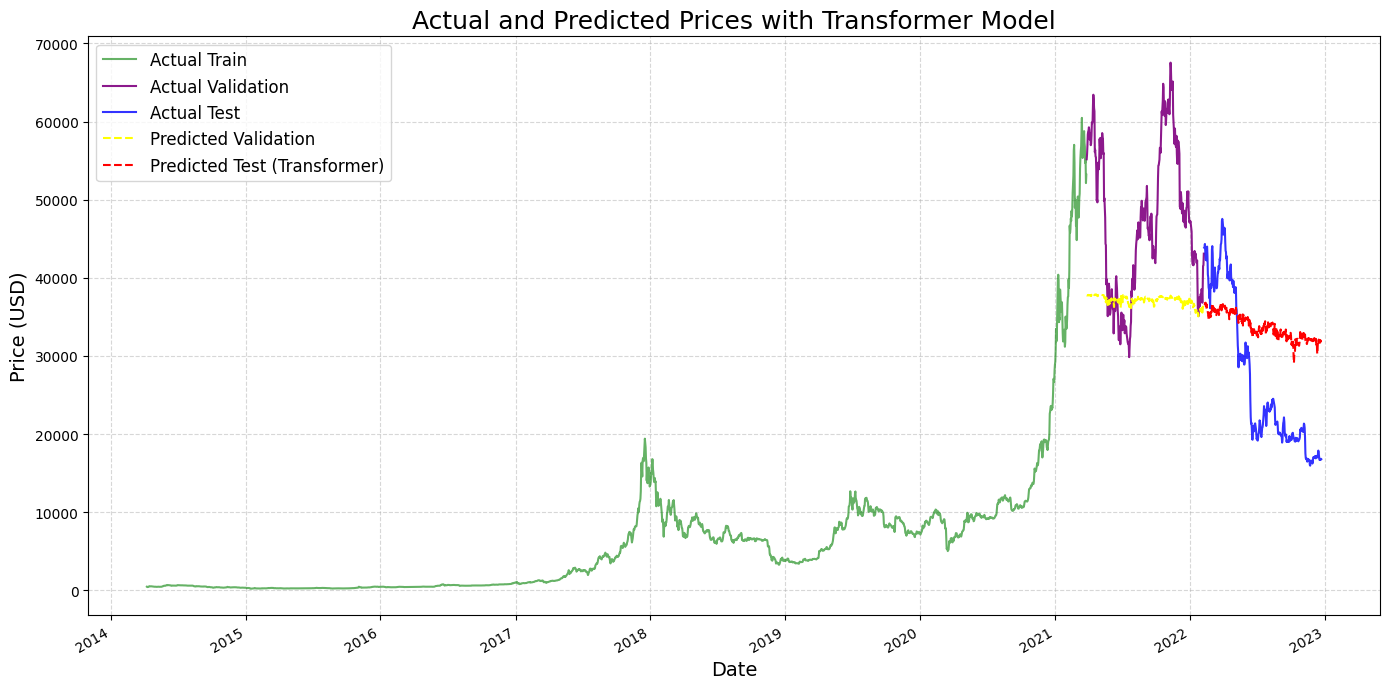

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Chuyển sang datetime (đảm bảo)
train_dates = pd.to_datetime(data['Date'].iloc[:len(y_train)])
val_dates = pd.to_datetime(data['Date'].iloc[len(y_train):len(y_train)+len(y_val)])
test_dates = pd.to_datetime(data['Date'].iloc[len(y_train)+len(y_val):])

plt.figure(figsize=(14, 7))

# Vẽ Actual Train
y_train_original = scaler.inverse_transform(y_train)
plt.plot(train_dates, y_train_original.flatten(), label='Actual Train', color='green', alpha=0.6)

# Vẽ Actual Validation
y_val_original = scaler.inverse_transform(y_val)
plt.plot(val_dates, y_val_original.flatten(), label='Actual Validation', color='purple', alpha=0.9)

# Vẽ Actual Test
plt.plot(test_dates, y_test_original.flatten(), label='Actual Test', color='blue', alpha=0.8)

# Vẽ Predicted Train
#plt.plot(train_dates, transformer_pred_train_original.flatten(), label='Predicted Train', linestyle='--', color='lime')

# Vẽ Predicted Validation
plt.plot(val_dates, transformer_pred_val_original.flatten(), label='Predicted Validation', linestyle='--', color='yellow')

# Vẽ Predicted Test (Transformer)
plt.plot(test_dates, transformer_pred_test_original.flatten(), label='Predicted Test (Transformer)', color='red', linestyle='--')

# Định dạng trục x
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.title('Actual and Predicted Prices with Transformer Model', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


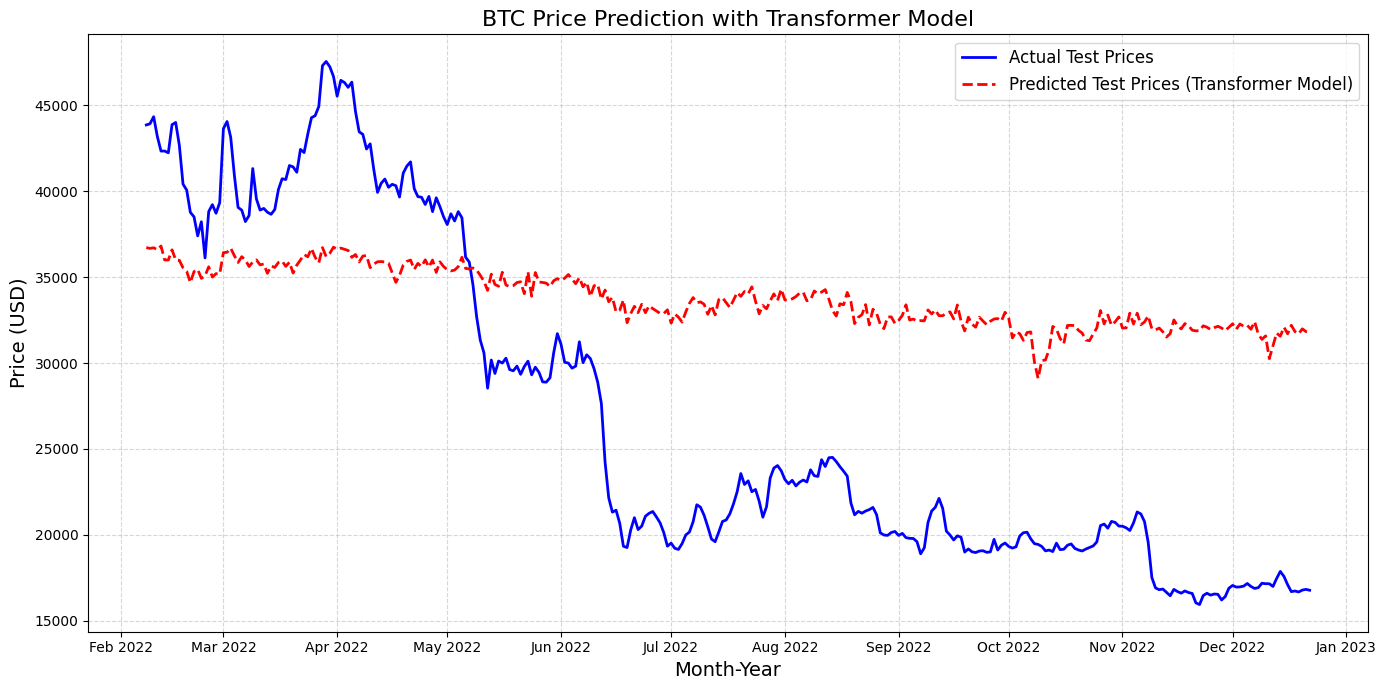

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Tính chỉ số chia tập dữ liệu 10% cuối test
split_index = int(len(data) * 0.9)

# Chuẩn bị dates cho tập test
dates_test = pd.to_datetime(data['Date'].iloc[split_index:])

plt.figure(figsize=(14, 7))

# Vẽ giá thực tế tập test
plt.plot(dates_test, y_test_original.flatten(),
         label='Actual Test Prices', color='blue', linewidth=2)

# Vẽ giá dự đoán tập test từ mô hình Transformer
plt.plot(dates_test, transformer_pred_test_original.flatten(),
         label='Predicted Test Prices (Transformer Model)',
         color='red', linestyle='--', linewidth=2)

# Định dạng trục x để hiển thị tháng và năm
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Thêm tiêu đề, nhãn trục và chú thích
plt.title('BTC Price Prediction with Transformer Model', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(fontsize=12)

# Thêm lưới và căn chỉnh bố cục
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()
